In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np
import pandas as pd
import random
import scipy as sp

import pytry

In [37]:
from sklearn.decomposition import PCA

class PatternInterpolationTrial(pytry.Trial):
    def params(self):
        self.param('number of neurons', n_neurons=2000),
        #self.param('number of training patterns', n_train_pattern=3)
        
    def evaluate(self, q):
        data = pd.read_csv("pinsoro-2017-06-20-145454904791-small.csv", low_memory=False)
        
        x = np.array(data.iloc[:,11:195]).astype(float)
        a = []
        for i in range(x.shape[1]):
            y = pd.Series(x[:,i])
            z = y.interpolate(limit_direction='both')
            a.append(z)
        a = pd.DataFrame(a)
        a = a.dropna()
        a = np.array(a).T

        dt = 0.001
        
        def extract_pattern(start, end):
            pattern = np.array(a[start:end,:]).astype(float)
            frames = np.array(data.iloc[start:end,9]).astype(int)

            good_indices = frames != -1
            frames = frames[good_indices]
            pattern = pattern[good_indices]

            fps = 30.0
            t_sample = (frames - frames[0])/fps

            t = np.arange(int(t_sample[-1]/dt))*dt

            result = []
            for i in range(pattern.shape[1]):       
                p = np.interp(t, t_sample, pattern[:,i])
                result.append(p)
            result = np.array(result).T

            return t, result


        t1, result1 = extract_pattern(374, 1790) #goaloriented
        t2, result2 = extract_pattern(2642, 3446) #goaloriented
        t3, result3 = extract_pattern(3867, 4637) #goaloriented
        t4, result4 = extract_pattern(5976, 7491) #goaloriented
        t5, result5 = extract_pattern(16968, 18323) #goaloriented
        t6, result6 = extract_pattern(18569, 19200) #goaloriented
        t7, result7 = extract_pattern(23672, 24737) #goaloriented 
        t8, result8 = extract_pattern(24966, 26142) #goaloriented
        t9, result9 = extract_pattern(26697, 26989) #goaloriented 
        t10, result10 = extract_pattern(27100, 27156) #goaloriented
        t11, result11 = extract_pattern(27212, 27983) #goaloriented
        t12, result12 = extract_pattern(27984, 30898) #goaloriented
        t13, result13 = extract_pattern(31201, 32875) #goaloriented
        t14, result14 = extract_pattern(32876, 35231) #goaloriented
        t15, result15 = extract_pattern(35232, 37106) #goaloriented
        t16, result16 = extract_pattern(37278, 37637) #goaloriented
        
        t17, result17 = extract_pattern(69, 373) #noplay
        t18, result18 = extract_pattern(1943, 2036) #noplay
        t19, result19 = extract_pattern(2195, 2344) #noplay
        t20, result20 = extract_pattern(4638, 4727) #noplay
        t21, result21 = extract_pattern(5162, 5396) #noplay
        t22, result22 = extract_pattern(7492, 7532) #noplay
        t23, result23 = extract_pattern(8257, 8350) #noplay
        t24, result24 = extract_pattern(9974, 10133) #noplay
        t25, result25 = extract_pattern(10523, 10592) #noplay
        t26, result26 = extract_pattern(10835, 11160) #noplay
        t27, result27 = extract_pattern(12128, 12369) #noplay
        t28, result28 = extract_pattern(13653, 13852) #noplay
        t29, result29 = extract_pattern(14210, 14272) #noplay
        t30, result30 = extract_pattern(14374, 14422) #noplay
        t31, result31 = extract_pattern(14485, 14648) #noplay
        t32, result32 = extract_pattern(14755, 14811) #noplay
        t33, result33 = extract_pattern(14973, 15459) #noplay
        t34, result34 = extract_pattern(18324, 18451) #noplay
        t35, result35 = extract_pattern(19201, 19262) #noplay
        t36, result36 = extract_pattern(24738, 24965) #noplay
        t37, result37 = extract_pattern(26143, 26696) #noplay
        t38, result38 = extract_pattern(26990, 27099) #noplay
        t39, result39 = extract_pattern(27157, 27211) #noplay
        t40, result40 = extract_pattern(30899, 30979) #noplay
        t41, result41 = extract_pattern(37107, 37277) #noplay
        t42, result42 = extract_pattern(37638, 38416) #noplay

        goal_list = [result1, result2, result3, result4, result5, result6, result7, result8, result9, 
                     result10, result11, result12, result13, result14, result15, result16]
        noplay_list = [result17, result18, result19, result20, result21, result22, result23, result24,
                      result25, result26, result27, result28, result29, result30, result31, result32,
                      result33, result34, result35, result36, result37, result38, result39, result40,
                      result41, result42]

       
        random.shuffle(goal_list)
        goal_train = goal_list[:11]
        goal_test = goal_list[11:]
        
        random.shuffle(noplay_list)
        noplay_train = noplay_list[:19]
        noplay_test = noplay_list[19:]
        
        train_all = np.vstack(goal_train+noplay_train)
        pca_model = PCA(n_components=1).fit(train_all)

        goal_patterns = {}
        i=0
        for gp in goal_train:
            goal_patterns[i] = pca_model.transform(gp)[:,0]
            i+=1

        noplay_patterns = {}
        i=0
        for npp in noplay_train:
            noplay_patterns[i] = pca_model.transform(npp)[:,0]
            i+=1

        goal_patterns = [(goal_patterns[key]) for key in goal_patterns.keys()]
        noplay_patterns = [(noplay_patterns[key]) for key in noplay_patterns.keys()] 

        theta = 1.0
        net = nengo.Network()
        with net:
            process = nengo.processes.WhiteSignal(period=100., high=1.0, y0=0)
            rw = nengolib.networks.RollingWindow(theta=theta, n_neurons=q.n_neurons, process=process, neuron_type=nengo.LIFRate(tau_rc=0.02, tau_ref=0.002, amplitude=1))
            
        s_window = int(theta/dt)
        s_pattern = min(len(goal_patterns[0]), len(goal_patterns[1]), len(goal_patterns[2]), len(goal_patterns[3]),
                       len(goal_patterns[4]), len(goal_patterns[5]), len(goal_patterns[6]), len(goal_patterns[7]),
                       len(goal_patterns[8]), len(goal_patterns[9]), len(goal_patterns[10]), len(noplay_patterns[0]), 
                       len(noplay_patterns[1]), len(noplay_patterns[2]), len(noplay_patterns[3]), len(noplay_patterns[4]),
                       len(noplay_patterns[5]), len(noplay_patterns[6]), len(noplay_patterns[7]), len(noplay_patterns[8]),
                       len(noplay_patterns[9]), len(noplay_patterns[10]), len(noplay_patterns[11]), len(noplay_patterns[12]),
                       len(noplay_patterns[13]), len(noplay_patterns[14]), len(noplay_patterns[15]), len(noplay_patterns[16]),
                       len(noplay_patterns[17]), len(noplay_patterns[18]))


        t_window = np.linspace(0, 1, s_window)
        inv_basis = rw.inverse_basis(t_window)

        eval_points=[]
        target = []
        for i in range(s_pattern):
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[0], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[1], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[2], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[3], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[4], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[5], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[6], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[7], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[8], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[9], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[10], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[0], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[1], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[2], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[3], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[4], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[5], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[6], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[7], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[8], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[9], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[10], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[11], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[12], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[13], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[14], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[15], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[16], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[17], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[18], i)[:s_window]))
            target.append([-1])

        eval_points = np.array(eval_points)
        
        with net:
            result = nengo.Node(None, size_in=1)
            nengo.Connection(rw.state, result,
                             eval_points=eval_points, scale_eval_points=True,
                             function=target, synapse=0.1)
            
        train_all =  np.hstack([goal_patterns[0], goal_patterns[1], goal_patterns[2], goal_patterns[3],
                               goal_patterns[4], noplay_patterns[0], noplay_patterns[1], noplay_patterns[2],
                               noplay_patterns[3], noplay_patterns[4]])
        presentation_time_test=30/len(train_all)
        
        model = nengo.Network()
        model.networks.append(net)
        with model:    
            stim = nengo.Node(nengo.processes.PresentInput(train_all, presentation_time=presentation_time_test))
            nengo.Connection(stim, rw.input, synapse=None)

            p_result = nengo.Probe(result)
            p_stim = nengo.Probe(stim)
        sim = nengo.Simulator(model)
        sim.run(30)

############ EXTRACT TEST PATTERNS ############ 
        goal_test_patterns = {}
        i=0
        for p in goal_test:
            goal_test_patterns[i] = pca_model.transform(p)[:,0]
            i+=1

        noplay_test_patterns = {}
        for p in noplay_test:
            noplay_test_patterns[i] = pca_model.transform(p)[:,0]
            i+=1

        patterns = {}
        patterns.update(goal_test_patterns)
        patterns.update(noplay_test_patterns)

        goal_test_patterns = [(goal_test_patterns[key]) for key in goal_test_patterns.keys()]
        noplay_test_patterns = [(noplay_test_patterns[key]) for key in noplay_test_patterns.keys()] 
        
        test_all =  np.hstack([goal_test_patterns[0], goal_test_patterns[1], goal_test_patterns[2], goal_test_patterns[3],
                               goal_test_patterns[4], noplay_test_patterns[0], noplay_test_patterns[1], noplay_test_patterns[2],
                               noplay_test_patterns[3], noplay_test_patterns[4], noplay_test_patterns[5], noplay_test_patterns[6]])
        presentation_time_test=30/len(test_all)
        
        model = nengo.Network()
        model.networks.append(net)
        with model:    
            stim = nengo.Node(nengo.processes.PresentInput(test_all, presentation_time=presentation_time_test))
            nengo.Connection(stim, rw.input, synapse=None)

            p_result = nengo.Probe(result)
            p_stim = nengo.Probe(stim)
        sim = nengo.Simulator(model)
        sim.run(30)
        
        
        ###################################################  
        
        gp1_len = int(len(goal_test_patterns[0])*presentation_time_test/dt)
        gp2_len = gp1_len+int(len(goal_test_patterns[1])*presentation_time_test/dt)
        gp3_len = gp2_len+int(len(goal_test_patterns[2])*presentation_time_test/dt)
        gp4_len = gp3_len+int(len(goal_test_patterns[3])*presentation_time_test/dt)
        gp5_len = gp4_len+int(len(goal_test_patterns[4])*presentation_time_test/dt)

        mean_gp1 = np.mean(sim.data[p_result][0:gp1_len])       
        mean_gp2 = np.mean(sim.data[p_result][gp1_len:gp2_len])
        mean_gp3 = np.mean(sim.data[p_result][gp2_len:gp3_len])
        mean_gp4 = np.mean(sim.data[p_result][gp3_len:gp4_len])
        mean_gp5 = np.mean(sim.data[p_result][gp4_len:gp5_len])
        
        npp1_len = gp5_len+int(len(noplay_test_patterns[0])*presentation_time_test/dt)
        npp2_len = npp1_len+int(len(noplay_test_patterns[1])*presentation_time_test/dt)
        npp3_len = npp2_len+int(len(noplay_test_patterns[2])*presentation_time_test/dt)
        npp4_len = npp3_len+int(len(noplay_test_patterns[3])*presentation_time_test/dt)
        npp5_len = npp4_len+int(len(noplay_test_patterns[4])*presentation_time_test/dt)
        npp6_len = npp5_len+int(len(noplay_test_patterns[5])*presentation_time_test/dt)
        npp7_len = npp6_len+int(len(noplay_test_patterns[6])*presentation_time_test/dt)
        
        mean_npp1 = np.mean(sim.data[p_result][gp5_len:npp1_len])       
        mean_npp2 = np.mean(sim.data[p_result][npp1_len:npp2_len])
        mean_npp3 = np.mean(sim.data[p_result][npp2_len:npp3_len])
        mean_npp4 = np.mean(sim.data[p_result][npp3_len:npp4_len])
        mean_npp5 = np.mean(sim.data[p_result][npp4_len:npp5_len])
        mean_npp6 = np.mean(sim.data[p_result][npp5_len:npp6_len])
        mean_npp7 = np.mean(sim.data[p_result][npp6_len:npp7_len])
        
        
################# TEST ON AIMLESS PATTERNS #################
        
        t43, result43 = extract_pattern(1791, 1942) 
        t44, result44 = extract_pattern(2037, 2194)
        t45, result45 = extract_pattern(2345, 2641)
        t46, result46 = extract_pattern(3447, 3866)
        t47, result47 = extract_pattern(4728, 5161)
        t48, result48 = extract_pattern(5397, 5975)
        t49, result49 = extract_pattern(7533, 8256)
        t50, result50 = extract_pattern(8351, 9973)
        t51, result51 = extract_pattern(10134, 10522)
        t52, result52 = extract_pattern(10593, 10834)
        t53, result53 = extract_pattern(11161, 12127)

        testp1 = pca_model.transform(result43)[:,0]
        testp2 = pca_model.transform(result44)[:,0]
        testp3 = pca_model.transform(result45)[:,0]
        testp4 = pca_model.transform(result46)[:,0]
        testp5 = pca_model.transform(result47)[:,0]
        testp6 = pca_model.transform(result48)[:,0]
        testp7 = pca_model.transform(result49)[:,0]
        testp8 = pca_model.transform(result50)[:,0]
        testp9 = pca_model.transform(result51)[:,0]
        testp10 = pca_model.transform(result52)[:,0]
        testp11 = pca_model.transform(result53)[:,0]
               
        p_all = np.hstack([testp1, testp2, testp3, testp4, testp5, testp6,
                          testp7, testp8, testp9, testp10, testp11])

        presentation_time_test=30/len(p_all)

        model = nengo.Network()
        model.networks.append(net)
        with model:    
            stim = nengo.Node(nengo.processes.PresentInput(p_all, presentation_time=presentation_time_test))
            nengo.Connection(stim, rw.input, synapse=None)

            p_result = nengo.Probe(result)
            p_stim = nengo.Probe(stim)
        sim = nengo.Simulator(model)
        sim.run(30)

        aim1_len = int(len(testp1)*presentation_time_test/dt)
        aim2_len = aim1_len+int(len(testp2)*presentation_time_test/dt)
        aim3_len = aim2_len+int(len(testp3)*presentation_time_test/dt)
        aim4_len = aim3_len+int(len(testp4)*presentation_time_test/dt)
        aim5_len = aim4_len+int(len(testp5)*presentation_time_test/dt)
        aim6_len = aim5_len+int(len(testp6)*presentation_time_test/dt)
        aim7_len = aim6_len+int(len(testp7)*presentation_time_test/dt)
        aim8_len = aim7_len+int(len(testp8)*presentation_time_test/dt)
        aim9_len = aim8_len+int(len(testp9)*presentation_time_test/dt)
        aim10_len = aim9_len+int(len(testp10)*presentation_time_test/dt)
        aim11_len = aim10_len+int(len(testp11)*presentation_time_test/dt)

        mean_aim1 = np.mean(sim.data[p_result][0:aim1_len])       
        mean_aim2 = np.mean(sim.data[p_result][aim1_len:aim2_len])
        mean_aim3 = np.mean(sim.data[p_result][aim2_len:aim3_len])
        mean_aim4 = np.mean(sim.data[p_result][aim3_len:aim4_len])
        mean_aim5 = np.mean(sim.data[p_result][aim4_len:aim5_len])
        mean_aim6 = np.mean(sim.data[p_result][aim5_len:aim6_len])
        mean_aim7 = np.mean(sim.data[p_result][aim6_len:aim7_len])
        mean_aim8 = np.mean(sim.data[p_result][aim7_len:aim8_len])
        mean_aim9 = np.mean(sim.data[p_result][aim8_len:aim9_len])
        mean_aim10 = np.mean(sim.data[p_result][aim9_len:aim10_len])
        mean_aim11 = np.mean(sim.data[p_result][aim10_len:aim11_len])
        
        return dict(
            mean_goal1=mean_gp1,
            mean_goal2=mean_gp2,
            mean_goal3=mean_gp3,
            mean_goal4=mean_gp4,
            mean_goal5=mean_gp5,
            mean_noplay1=mean_npp1,
            mean_noplay2=mean_npp2,
            mean_noplay3=mean_npp3,
            mean_noplay4=mean_npp4,
            mean_noplay5=mean_npp5,
            mean_noplay6=mean_npp6,
            mean_noplay7=mean_npp7,
            mean_aim1=mean_aim1,
            mean_aim2=mean_aim2,
            mean_aim3=mean_aim3,
            mean_aim4=mean_aim4,
            mean_aim5=mean_aim5,
            mean_aim6=mean_aim6,
            mean_aim7=mean_aim7,
            mean_aim8=mean_aim8,
            mean_aim9=mean_aim9,
            mean_aim10=mean_aim10,
            mean_aim11=mean_aim11
        )


running PatternInterpolationTrial#20190128-163944-b3cab7b2
[array([[ 0.4444  ,  0.4747  ,  0.4597  , ..., -0.758   ,  0.651   ,
        -0.044   ],
       [ 0.443515,  0.474754,  0.459031, ..., -0.75788 ,  0.65115 ,
        -0.044   ],
       [ 0.44263 ,  0.474808,  0.458362, ..., -0.75776 ,  0.6513  ,
        -0.044   ],
       ...,
       [ 0.56493 ,  0.57538 ,  0.59929 , ...,  0.1117  ,  0.7863  ,
        -0.6072  ],
       [ 0.564891,  0.575386,  0.599203, ...,  0.11179 ,  0.78681 ,
        -0.60654 ],
       [ 0.564852,  0.575392,  0.599116, ...,  0.11188 ,  0.78732 ,
        -0.60588 ]]), array([[ 0.4035  ,  0.6654  ,  0.4347  , ...,  0.096   ,  0.862   ,
        -0.498   ],
       [ 0.403308,  0.665352,  0.434487, ...,  0.09579 ,  0.86251 ,
        -0.49713 ],
       [ 0.403116,  0.665304,  0.434274, ...,  0.09558 ,  0.86302 ,
        -0.49626 ],
       ...,
       [ 0.411037,  0.684434,  0.433544, ...,  0.13402 ,  0.87922 ,
        -0.457   ],
       [ 0.411136,  0.684452,  0.4

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
mean_aim1 = 0.20293723434132638
mean_aim10 = -0.7612759621824967
mean_aim11 = -1.430435740021367
mean_aim2 = -0.9141296197593171
mean_aim3 = -0.10199107915655982
mean_aim4 = -0.2952105904625782
mean_aim5 = 0.24584725613456207
mean_aim6 = 0.020621960077506836
mean_aim7 = -0.9560673547226982
mean_aim8 = -1.2219245181392087
mean_aim9 = -0.5853219659624275
mean_goal1 = 0.0004889313072241311
mean_goal2 = -1.0051325368638022
mean_goal3 = -1.1240973710644517
mean_goal4 = -0.09255820587875489
mean_goal5 = -0.9933881001173769
mean_noplay1 = -0.954286167677078
mean_noplay2 = -0.6750105741117733
mean_noplay3 = -0.8763963928655422
mean_noplay4 = -1.0211840318110188
mean_noplay5 = -1.1843732778776497
mean_noplay6 = -1.1628115709412135
mean_noplay7 = -1.091037649784712


{'mean_goal1': 0.0004889313072241311,
 'mean_goal2': -1.0051325368638022,
 'mean_goal3': -1.1240973710644517,
 'mean_goal4': -0.09255820587875489,
 'mean_goal5': -0.9933881001173769,
 'mean_noplay1': -0.954286167677078,
 'mean_noplay2': -0.6750105741117733,
 'mean_noplay3': -0.8763963928655422,
 'mean_noplay4': -1.0211840318110188,
 'mean_noplay5': -1.1843732778776497,
 'mean_noplay6': -1.1628115709412135,
 'mean_noplay7': -1.091037649784712,
 'mean_aim1': 0.20293723434132638,
 'mean_aim2': -0.9141296197593171,
 'mean_aim3': -0.10199107915655982,
 'mean_aim4': -0.2952105904625782,
 'mean_aim5': 0.24584725613456207,
 'mean_aim6': 0.020621960077506836,
 'mean_aim7': -0.9560673547226982,
 'mean_aim8': -1.2219245181392087,
 'mean_aim9': -0.5853219659624275,
 'mean_aim10': -0.7612759621824967,
 'mean_aim11': -1.430435740021367}

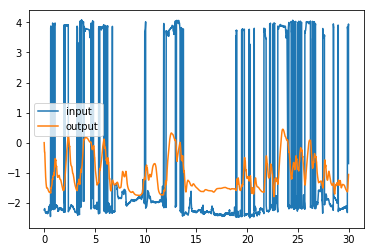

In [38]:
PatternInterpolationTrial().run(data_dir='debug')

running PatternInterpolationTrial#20190128-164829-3bb655f1
[array([[ 0.4444  ,  0.4747  ,  0.4597  , ..., -0.758   ,  0.651   ,
        -0.044   ],
       [ 0.443515,  0.474754,  0.459031, ..., -0.75788 ,  0.65115 ,
        -0.044   ],
       [ 0.44263 ,  0.474808,  0.458362, ..., -0.75776 ,  0.6513  ,
        -0.044   ],
       ...,
       [ 0.56493 ,  0.57538 ,  0.59929 , ...,  0.1117  ,  0.7863  ,
        -0.6072  ],
       [ 0.564891,  0.575386,  0.599203, ...,  0.11179 ,  0.78681 ,
        -0.60654 ],
       [ 0.564852,  0.575392,  0.599116, ...,  0.11188 ,  0.78732 ,
        -0.60588 ]]), array([[ 0.4035  ,  0.6654  ,  0.4347  , ...,  0.096   ,  0.862   ,
        -0.498   ],
       [ 0.403308,  0.665352,  0.434487, ...,  0.09579 ,  0.86251 ,
        -0.49713 ],
       [ 0.403116,  0.665304,  0.434274, ...,  0.09558 ,  0.86302 ,
        -0.49626 ],
       ...,
       [ 0.411037,  0.684434,  0.433544, ...,  0.13402 ,  0.87922 ,
        -0.457   ],
       [ 0.411136,  0.684452,  0.4

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 200
mean_aim1 = 0.13994522336577958
mean_aim10 = -0.1378933320771795
mean_aim11 = -0.4431765301695861
mean_aim2 = -0.13285830894619777
mean_aim3 = 0.13653264285849506
mean_aim4 = 0.15657160979571916
mean_aim5 = 0.4516224662401109
mean_aim6 = 0.3390619860109011
mean_aim7 = -0.15114770610610323
mean_aim8 = -0.675804323318065
mean_aim9 = 0.05579057418016118
mean_goal1 = -0.29460376325176585
mean_goal2 = -0.2992883450440484
mean_goal3 = -0.09656563208268955
mean_goal4 = -0.04811147959182961
mean_goal5 = -0.42534505543186263
mean_noplay1 = -0.3143293280935309
mean_noplay2 = -0.3434608995795396
mean_noplay3 = -0.29278207473388324
mean_noplay4 = -0.3419502024167263
mean_noplay5 = -0.1857556639014532
mean_noplay6 = -0.2621099756390879
mean_noplay7 = -0.403786580278328
running PatternInterpolationTrial#20190128-164908-724070c2
[array([[ 0.4444  ,  0.4747  ,  0.4597  , ..., -0.758   ,  0.651   ,
        -0.044   ],
       [ 0.443515,  0.474754,  0.459031, ..., -0.75788 ,  0.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 500
mean_aim1 = 0.024032844531757656
mean_aim10 = -0.20179595943868778
mean_aim11 = -0.532182464992072
mean_aim2 = -0.19200352543014831
mean_aim3 = 0.032067748425088305
mean_aim4 = 0.06522111593164721
mean_aim5 = 0.3246956464017141
mean_aim6 = 0.20859986994459517
mean_aim7 = -0.21334976823150698
mean_aim8 = -0.6562952301917327
mean_aim9 = 0.1195730938498245
mean_goal1 = -0.4306012104228061
mean_goal2 = -0.3124915724467519
mean_goal3 = -0.2525116199359089
mean_goal4 = -0.2553490269758084
mean_goal5 = -0.6118933072645804
mean_noplay1 = -0.4724570851517026
mean_noplay2 = -0.7286118864764296
mean_noplay3 = -0.6752654410102373
mean_noplay4 = -0.6782690546377745
mean_noplay5 = -0.53827741104737
mean_noplay6 = -0.4773242238850527
mean_noplay7 = -0.6899783969065048
running PatternInterpolationTrial#20190128-164954-06e8817e
[array([[ 0.4444  ,  0.4747  ,  0.4597  , ..., -0.758   ,  0.651   ,
        -0.044   ],
       [ 0.443515,  0.474754,  0.459031, ..., -0.75788 ,  0.651

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 1000
mean_aim1 = 0.14589370364741192
mean_aim10 = -0.23538061620160328
mean_aim11 = -0.6781890334267645
mean_aim2 = -0.32973089220243335
mean_aim3 = 0.14462569255210192
mean_aim4 = 0.09538625808047012
mean_aim5 = 0.45958304638130515
mean_aim6 = 0.25218753939256094
mean_aim7 = -0.26331311727197904
mean_aim8 = -0.7898621141913456
mean_aim9 = 0.14077315405453592
mean_goal1 = -0.5623136311908552
mean_goal2 = -0.512812126304713
mean_goal3 = -0.36034410044998394
mean_goal4 = -0.3441851125820952
mean_goal5 = -0.7988191281241633
mean_noplay1 = -0.7077016275230146
mean_noplay2 = -0.9547477859043199
mean_noplay3 = -1.0060938573707958
mean_noplay4 = -0.6617633699409847
mean_noplay5 = -0.7896312850386049
mean_noplay6 = -0.7488531338853254
mean_noplay7 = -0.7945847658037751
running PatternInterpolationTrial#20190128-165048-fb3d9645
[array([[ 0.4444  ,  0.4747  ,  0.4597  , ..., -0.758   ,  0.651   ,
        -0.044   ],
       [ 0.443515,  0.474754,  0.459031, ..., -0.75788 ,  0

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
mean_aim1 = -0.21974382837206477
mean_aim10 = -0.5846192514345531
mean_aim11 = -1.0700222094124792
mean_aim2 = -0.9188170774778128
mean_aim3 = -0.10671450856559968
mean_aim4 = -0.3509282618820042
mean_aim5 = -0.07288053876770562
mean_aim6 = -0.16834599327709227
mean_aim7 = -0.6947701739135537
mean_aim8 = -1.0134433875938131
mean_aim9 = -0.5958733446740214
mean_goal1 = -1.0783863944807823
mean_goal2 = -1.186365069525412
mean_goal3 = -0.5702925513456925
mean_goal4 = -0.5306724759095097
mean_goal5 = -0.9216113273156885
mean_noplay1 = -0.7409160861345284
mean_noplay2 = -1.2512893072376878
mean_noplay3 = -1.238521013826682
mean_noplay4 = -1.195171657248115
mean_noplay5 = -0.6223914794168912
mean_noplay6 = -0.7666415771865606
mean_noplay7 = -1.2468901043530514
running PatternInterpolationTrial#20190128-165202-73c2f8bd
[array([[ 0.4444  ,  0.4747  ,  0.4597  , ..., -0.758   ,  0.651   ,
        -0.044   ],
       [ 0.443515,  0.474754,  0.459031, ..., -0.75788 ,  0.6

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 5000
mean_aim1 = -0.08166010558678374
mean_aim10 = -0.7841834437275902
mean_aim11 = -1.249897169239698
mean_aim2 = -0.903792739596171
mean_aim3 = -0.14014483968639072
mean_aim4 = -0.40862016822157843
mean_aim5 = 0.24665020124358755
mean_aim6 = -0.24441050817787316
mean_aim7 = -0.6959378406581939
mean_aim8 = -1.375409742142121
mean_aim9 = -0.36687365273861466
mean_goal1 = -1.323324352100895
mean_goal2 = -1.2925536024703574
mean_goal3 = -0.941265578113285
mean_goal4 = -0.9043534806470935
mean_goal5 = -1.4457859443493137
mean_noplay1 = -1.609265104987159
mean_noplay2 = -1.8156065974727233
mean_noplay3 = -1.654744435877227
mean_noplay4 = -1.3716216942209984
mean_noplay5 = -1.514806917575293
mean_noplay6 = -1.1753999929780699
mean_noplay7 = -1.8117274158415615


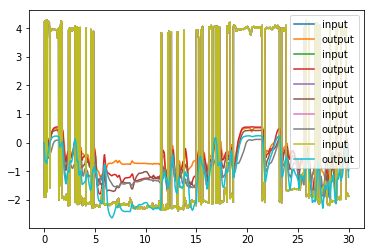

In [40]:
for seed in range(1):
    for n_neurons in [200, 500, 1000, 2000, 5000]:
        PatternInterpolationTrial().run(seed=seed, n_neurons=n_neurons,
                                        data_dir='vary_neurons_child-robot')